In [0]:
import numpy as np  # biblioteca utilizada para tratar com número/vetores/matrizes
import matplotlib.pyplot as plt  # utilizada para plotar gráficos ao "estilo" matlab
import pandas as pd #biblioteca utilizada para realizar operações sobre dataframes


In [2]:
from google.colab import files  #biblioteca do google colab utilizada para importar arquivos 
uploaded=files.upload() #importa os arquivos

Saving AAPL.csv to AAPL.csv


In [0]:
import io  #biblioteca utilizada para tratar os comandos de entrada e saida
data = pd.read_csv(io.BytesIO(uploaded['AAPL.csv'])) # utilizado para importar o arquivo CSV que contém o banco de dados

In [5]:
data.head() #comando utilizado para mostrar as 5 primeiras colunas do dataframe

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,79.117142,79.285713,77.375717,78.432854,68.502106,140129500
1,2013-01-03,78.268570,78.524284,77.285713,77.442856,67.637436,88241300
2,2013-01-04,76.709999,76.947144,75.118568,75.285713,65.753418,148583400
3,2013-01-07,74.571426,75.614288,73.599998,74.842857,65.366646,121039100
4,2013-01-08,75.601425,75.984283,74.464287,75.044289,65.542587,114676800


Text(0.5, 0, 'Data')

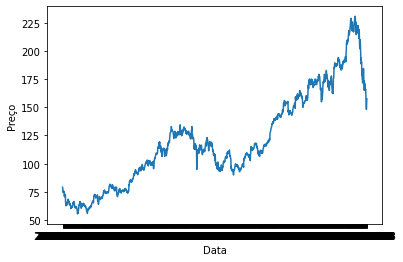

In [6]:
plt.plot(data["Date"],data["Open"])
plt.ylabel("Preço")
plt.xlabel("Data")

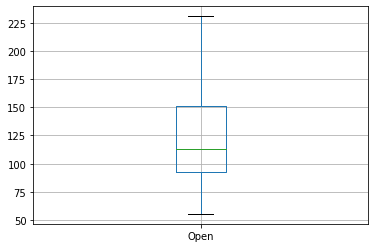

In [7]:
#comando utilizado para gerar o boxplot
#boxplot é empregado para ver se existem outlier
data.boxplot(column='Open')

In [9]:
#comando utilizado para verificar se existem dados nulos, numéricos ou não
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1509 entries, 0 to 1508
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1509 non-null   object 
 1   Open       1509 non-null   float64
 2   High       1509 non-null   float64
 3   Low        1509 non-null   float64
 4   Close      1509 non-null   float64
 5   Adj Close  1509 non-null   float64
 6   Volume     1509 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 82.6+ KB


In [10]:
#preparando os dados para a entrada
entradas=data.iloc[:,1:2].values # retira do dataframe apenas a coluna relativa ao preço de abertura das ações
entradas[:5] #utilizada para realiar um print apenas das 5 primeiras linhas (pode ser visto que esse é um array, não um dataframe)

array([[79.117142],
       [78.26857 ],
       [76.709999],
       [74.571426],
       [75.601425]])

In [0]:
#normalizando os dados (os algoritmos de ML, em geral, não trabalham bem com dados em escalas diferentes)
from sklearn.preprocessing import MinMaxScaler  #biblioteca utilizada para realizar o preprocessamento dos dados
scaler = MinMaxScaler(feature_range = (0, 1))    #cria o objeto que será utilizado para realizar a normalização dos dados
                                                 # feaure_range = define o intervalo de escala dos dados

dados_normalizados = scaler.fit_transform(entradas)  # aplica o método de transformação dos dados

In [12]:
dados_normalizados[:5]

array([[0.13511311],
       [0.13027396],
       [0.12138591],
       [0.10919028],
       [0.11506405]])

In [0]:
#Como as redes recorrentes utilizam dados no tempo T e valores passados (T-n), a entrada da rede deve conter os 
#valores presentes e os (T-n). Assim, é necessário realizar uma modificação nos dados
features_set = []  
labels = []  
for i in range(60, 1259):  
    features_set.append(dados_normalizados[i-60:i, 0])
    labels.append(dados_normalizados[i, 0])

In [0]:
#transformando os dados em um array para serem utilizados como entrada
features_set, labels = np.array(features_set), np.array(labels)  

In [15]:
#conferindo a dimensão dos dados
print(features_set.shape) # método utilizado para retornar a dimensão dos dados
print(labels.shape)

(1199, 60)
(1199,)


In [16]:
#transformando os dados para o formato aceito pelas redes recorrentes do Keras
# 1 - formato em 3D
# (a,b,c) -> a = número de linhas do dataset
#         -> b = número de steps (entradas) da rede
#         -> c = número de saídas (indicators)

# método da biblioteca numpy que é utilizado para converter os dados de entrada (1199,60) em (1199,60,1)
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))  # 
print(features_set.shape)

(1199, 60, 1)


In [0]:
from keras.models import Sequential  #classe utilizada para criar o modelo sequencial utilizando o keras
from keras.layers import Dense  # Classe utilizada para criar as camadas que são completamente conectadas
from keras.layers import LSTM  # Classe para a rede recorrente utilizando Long Shor Term Memory
from keras.layers import Dropout # Classe utilizada para a camada de dropout (utilizada para evitar o overfiting)

In [0]:
model = Sequential()  # objeto para a criação do modelo keras sequencial
model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set.shape[1], 1)))  #cria a camada de entrada
# como pode ser visto, ela é adicionada como uma pilha, cada nova camada é adicionada com o método add
# na camada de entrada, é necessário definir o tamanho do vetor de entrada (input_shape)
# units=50 indica que na camada de entrada devem existir 50 neurônios
# return_sequences= True indica que devem ser adicionadas novas camadas


In [0]:
#adição da camada de dropout
model.add(Dropout(0.2))  # o valor de 0.2 indica que 20% dos neurônios dessa camada serão perdidos para cada interação

In [0]:
#Adicionando mais camadas ao modelo 
model.add(LSTM(units=50, return_sequences=True))  
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))  
model.add(Dropout(0.2))

model.add(LSTM(units=50))  # como essa é a última camada LSTM utilizada, a variável return_sequences=False 
model.add(Dropout(0.2))  

In [0]:
#adiciona a camada de saída com apenas 1 neurônio, pois vamos realizar a previsão de apenas uma variável (Previsão do valor de abertura)
model.add(Dense(units = 1))

In [24]:
#comando utilizado para ver a configuração do nosso modelo
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 50)           

In [0]:
#definição do tipo de função perda a ser utilizada e do tipo do otimizador 
# o otimizador é utilizado para minimizar a função perda
# a função perda indica como deve ser calculado o erro do modelo (valor real - valor previsto)
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [26]:
#treinamento do modelo
model.fit(features_set, labels, epochs = 100, batch_size = 32)  
# valores de entrada
# saída
# número épocas para o treinamento (vezes em que vamos realizar interações durante o treinamento)
#batch_size = quantidade de dados utilizados por vez para realizar o treinamento

Epoch 1/100
1199/1199 [==============================] - 18s 15ms/step - loss: 0.0159
Epoch 2/100
1199/1199 [==============================] - 15s 13ms/step - loss: 0.0030
Epoch 3/100
1199/1199 [==============================] - 15s 13ms/step - loss: 0.0022
Epoch 4/100
1199/1199 [==============================] - 15s 12ms/step - loss: 0.0020
Epoch 5/100
1199/1199 [==============================] - 16s 13ms/step - loss: 0.0020
Epoch 6/100
 544/1199 [============>.................] - ETA: 8s - loss: 0.0020

KeyboardInterrupt: ignored

In [27]:
uploaded2=files.upload() #importa os arquivos para o teste dos dados 

Saving AAPL_previsao.csv to AAPL_previsao.csv


In [0]:
data_test = pd.read_csv(io.BytesIO(uploaded2['AAPL_previsao.csv'])) # utilizado para importar o arquivo CSV que contém o banco de dados para teste

In [30]:
data_test.head() #verifica as 5 primeiras linhas do dataframe utilizado para teste

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,154.889999,158.850006,154.229996,157.919998,154.794983,37039700
1,2019-01-03,143.979996,145.720001,142.000000,142.190002,139.376251,91312200
2,2019-01-04,144.529999,148.550003,143.800003,148.259995,145.326126,58607100
3,2019-01-07,148.699997,148.830002,145.899994,147.929993,145.002686,54777800
4,2019-01-08,149.559998,151.820007,148.520004,150.750000,147.766861,41025300


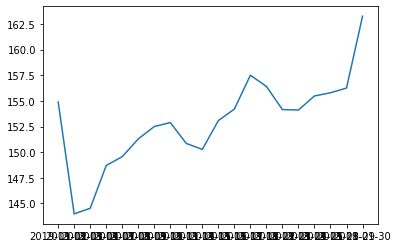

In [31]:
plt.plot(data_test.Date,data_test.Open) #plot para os dados a serem utilizados como teste

In [0]:
df_data_apple=data_test.iloc[:, 1:2].values

In [0]:
df_data_apple = pd.concat((data['Open'], data_test['Open']), axis=0)  # concatena os dados utilizados para teste e os utilizados para treinamento, tudo em um mesmo dataframe de 1 coluna


In [34]:
df_data_apple.head()

0    79.117142
1    78.268570
2    76.709999
3    74.571426
4    75.601425
Name: Open, dtype: float64

In [0]:
test_inputs = df_data_apple[len(df_data_apple) - len(data_test) - 60:].values  


In [0]:
#normalização dos dados para teste, como fizemos com os dados de treinamento
test_inputs = test_inputs.reshape(-1,1)  
test_inputs = scaler.transform(test_inputs)  

In [0]:
#preparação dos 60 dados a setem utilizado
test_features = []  
for i in range(60, 80):  
    test_features.append(test_inputs[i-60:i, 0])

In [0]:
#preparando os dados como entrada para o modelo de previsão 
test_features = np.array(test_features)  
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1)) 

In [0]:
#previsão utilizando o modelo gerado 
previsao = model.predict(test_features)  

In [0]:
#inverte a transformação (normalização) dos dados de previsão
previsao = scaler.inverse_transform(previsao)

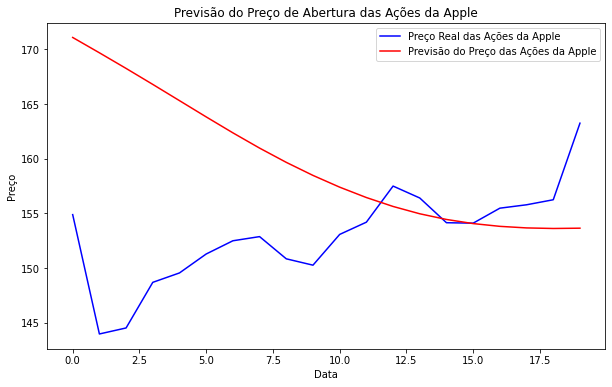

In [41]:
#plot do resultado da previsão e do real
plt.figure(figsize=(10,6))  
plt.plot(data_test.Open, color='blue', label='Preço Real das Ações da Apple')  
plt.plot(previsao , color='red', label='Previsão do Preço das Ações da Apple')  
plt.title('Previsão do Preço de Abertura das Ações da Apple')  
plt.xlabel('Data')  
plt.ylabel('Preço')  
plt.legend()  
plt.show() 